# Voxel debugging

This is a notebook to work on debugging the voxel properties. Here you can check the absorption, emissivity, and intensity of the voxel, as well as perform gaussian fits to these properties. This is to help ensure everything works as expected (the emissivity and absorption should have the same gaussian line width).

In [1]:
from kosmatau3d import models
import numpy as np

np.set_printoptions(precision=8)

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = { \
                # Model parameters
                'resolution' : 0.001, \
                 'molecules' : 'all', \
                      'dust' : 'PAH', \
            'clumpMassRange' : [[-1]], \
           'clumpMassNumber' : [1], \
              'clumpDensity' : [None], \
                  'clumpFUV' : [None], \
                 'clumpNmax' : [1], \
             'velocityRange' : [-10, 10], \
            'velocityNumber' : 201, \

                # Voxel properties
                      'mass' : 0.0001, \
                 'clumpMass' : 0.0001, \
                  'velocity' : 0., \
        'ensembleDispersion' : 1, \
                   'density' : 1e4, \
                       'FUV' : 1e4 \
          }

vox = models.Voxel()
vox.setProperties(**parameters)
vox.calculateEmission(verbose=True)

Voxel emission calculated.


In [2]:
models.ensemble.clumpNormalisedNj[0], models.ensemble.clumpNormalisedDeltaNji[0].max()

(array([[6.61431144]]), 1.0)

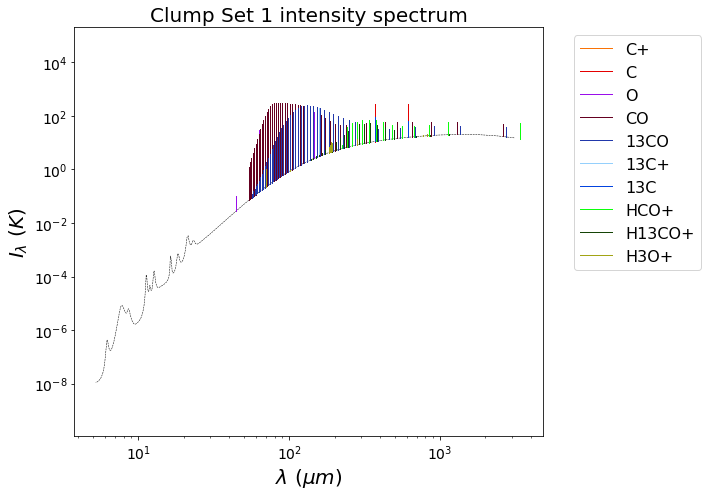

In [131]:
vox.plotSpectrum()

In [42]:
molecules = ['C+ 1', '13C+ 1']

In [26]:
models.masspoints.clumpIntensity[0][:,models.species.speciesIndeces(['C+ 1', '13C+ 1'])]

array([[86.05676646,  3.92075915]])

In [125]:
models.masspoints.clumpOpticalDepth[0][:,models.species.speciesIndeces(['C+ 1', '13C+ 1'])]

array([[0.53109591, 0.00816126]])

In [132]:
i = models.masspoints.clumpIntensity[0][0,models.species.speciesIndeces(molecules)]
t = models.masspoints.clumpOpticalDepth[0][0,models.species.speciesIndeces(molecules)]

i/t*(1-np.exp(-t))

array([64.16091865,  1.64995403])

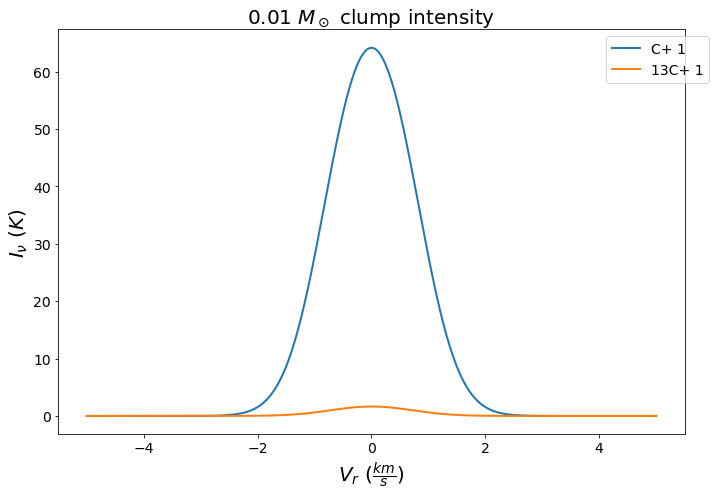

In [126]:
models.masspoints.plotIntensity(molecule=['C+ 1', '13C+ 1'])

In [133]:
e = vox.getEmissivity()[0][:,models.species.speciesIndeces(molecules)].max(0)
a = vox.getAbsorption()[0][:,models.species.speciesIndeces(molecules)].max(0)
ds = models.constants.resolution

e/a*(1-np.exp(-a*ds))

array([155.71536767, 202.74751593])

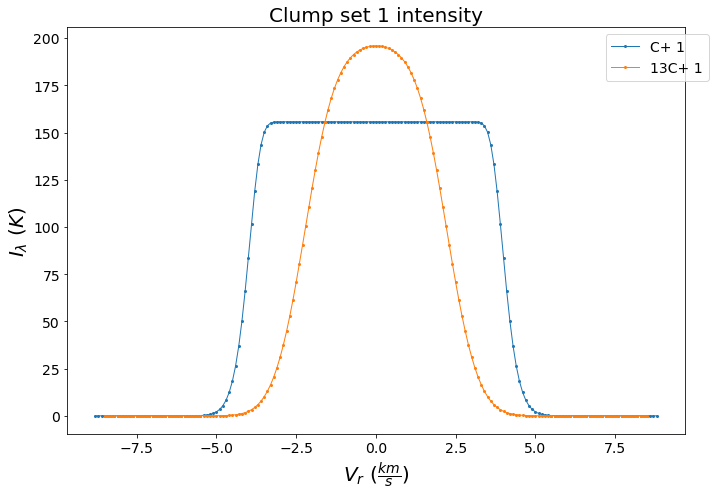

In [136]:
vox.plotMolecule(molecule=['C+ 1', '13C+ 1'])

In [30]:
models.ensemble.printEnsembleParameters()


C L U M P   S E T   1

Nj:
[[0.]]
delta Nji:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]


C 1 absorption coefficient: 14.801122285670195
C 1 emissivity coefficient: 2061.8081079604717
sigma 1.2224042546994702 -1.222403903395177


/home/craig/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


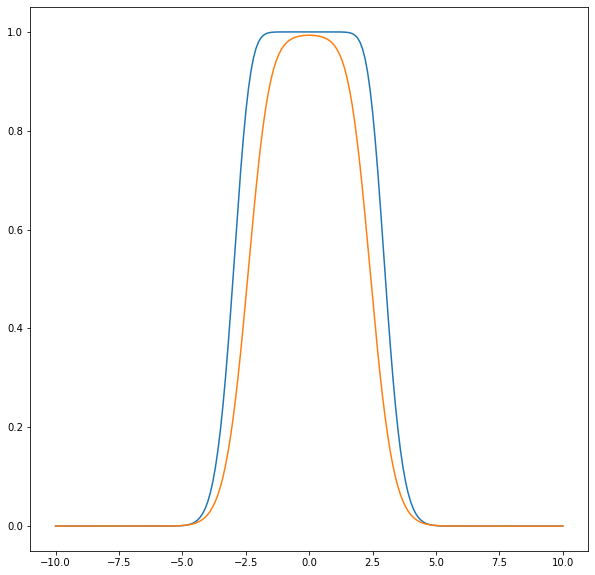

In [37]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

vel = models.constants.velocityRange
cVel = vox.getClumpVelocity()[0]
prob = models.ensemble.clumpProbability[0].prod(2)
eps = vox.getEmissivity()[0]
kap = vox.getAbsorption()[0]
tau = np.array([(prob[i,:].reshape(-1,1)*np.exp(-models.combinations.clumpOpticalDepth[0])) for i in range(prob.shape[0])])
inten = np.array([(prob[i,:].reshape(-1,1)*models.combinations.clumpIntensity[0]) for i in range(prob.shape[0])])
scale = models.constants.resolution
# a = (kap/np.sqrt(2*(kap/scale).astype(np.complex)))
# b = ((kap+kap)/np.sqrt(2*(kap/scale).astype(np.complex)))
# aE = np.array(list(models.radiativeTransfer.Ereal(a)))
# bE = np.array(list(models.radiativeTransfer.Ereal(b)))
intensity = eps/kap * (1-np.exp(-kap*scale))
# intensity_rad = (eps/kap*(1-np.exp(-kap*scale-kap/2.*scale)) - \
#                         (eps*kap/scale-eps*kap/scale)*scale/kap * \
#                         np.sqrt(np.pi/(2.*abs(kap.astype(np.complex)))) * \
#                         (np.exp(a**2.-b**2.)*aE-bE) + \
#                         0*np.exp(-kap*scale-kap/2.*scale)).real
tauc = models.combinations.clumpOpticalDepth[0]

# Choose the species to plot
imol = 202
print('{} absorption coefficient: {}'.format(models.constants.molecules[imol-201],kap[:,imol].max()*scale))
print('{} emissivity coefficient: {}'.format(models.constants.molecules[imol-201],eps[:,imol].max()*scale))

# Perform gaussian fits on the absorption, emissivity, and optical depth
kpopt,kpcov = curve_fit(gaus,vel,kap[:,imol],p0=[1,0,1])
epopt,epcov = curve_fit(gaus,vel,eps[:,imol],p0=[1,0,1])
print('sigma', kpopt[-1], epopt[-1])   #show the line widths of the gaussian fits
kpopt[-1] = epopt[-1]
kpopt[0] = 5e0
# epopt[-1] = kpopt[-1]
cpopt,cpcov = curve_fit(gaus,cVel,-np.log(tau.sum(1))[:,imol],p0=[1,0,1])
intensity_fit = gaus(vel,*epopt)/gaus(vel,*kpopt) * (1-np.exp(-gaus(vel,*kpopt)*scale))

# Plot to find the source of error
plt.figure(figsize=(10,10))
# plt.plot(vel, (eps[:,imol]-gaus(vel,*kpopt))/eps[:,imol])
# plt.plot(vel, eps[:,imol]/kap[:,imol])
plt.plot(vel, (1-np.exp(-kap[:,imol])))
plt.plot(vel, (1-np.exp(-gaus(vel,*kpopt))))
# plt.plot(vel, gaus(vel,*kpopt)/gaus(vel,*kpopt))

# # Plot the voxel intensity and fitted intensity
# plt.figure(figsize=(10,10))
# plt.plot(vel, intensity[:,imol])
# plt.plot(vel, intensity_fit, ls=':', lw=3)
# # plt.plot(vel, intensity_rad[:,imol])

# # Plot emissivity
# plt.figure(figsize=(10,10))
# plt.plot(vel, eps[:,imol])

# # Plot absorption
# plt.figure(figsize=(10,10))
# plt.plot(vel, kap[:,imol])

# # Plot probability
# plt.figure(figsize=(10,10))
# # plt.plot(vel, tauc[:,imol])
# plt.semilogy(np.arange(prob.shape[0]), prob.sum(1))
# print(np.log10(prob.sum(1)).min(), np.log10(prob.sum(1)).max())   #print maximum error in probability
# plt.ylim([1-1e-19,1+1e-19])

# # Plot optical depth
# # plt.plot(cVel, inten.sum(1)[:,imol])
# plt.figure(figsize=(10,10))
# plt.plot(cVel, -np.log(tau.sum(1))[:,imol])
# plt.plot(cVel, gaus(cVel,*cpopt), ls=':', lw=3)

# # Plot number of clumps
# plt.figure(figsize=(10,10))
# plt.scatter(vel, models.ensemble.clumpNormalisedDeltaNji[0])

In [3]:
# Define how many clump are in a line-of-sight
nClumps = 661
# Get the clump radius
rcl = models.masspoints.clumpRadius[0][0,0]
# Specify transitions
molecules = ['dust 3.1mm', 'C+ 1', 'C 1', 'C 2', 'O 1', 'O 2', 'CO 1', 'CO 25', '13C 1']
# get the clump intensity and optical depth for the required transitions
icl = models.masspoints.clumpIntensity[0][0,models.species.speciesIndeces(molecules)]
tcl = models.masspoints.clumpOpticalDepth[0][0,models.species.speciesIndeces(molecules)]

print('Clump intensities:')
for i,I in enumerate(icl/tcl*(1-np.exp(-tcl))):
  print('{:>10}: {:.6} K'.format(molecules[i], I))
print('\n')

# Initialise the line intensities
I = np.zeros(icl.size)

# Integrate over the number of clumps along a line-of-sight
for i in range(nClumps):
  I = np.exp(-tcl) * ( icl/tcl*(np.exp(tcl)-1) + I )
  
# Integrate in an alternate simplified equation
# I = icl/tcl * (1-np.exp(-nClumps*tcl))

for i,transition in enumerate(molecules):
  print('The brightness temperature of the {:10} transition is {:.6} K'.format(transition, I[i]))

Clump intensities:
dust 3.1mm: 0.0331402 K
      C+ 1: 85.8156 K
       C 1: 5.31062 K
       C 2: 8.25942 K
       O 1: 25.7146 K
       O 2: 78.5478 K
      CO 1: 23.6706 K
     CO 25: 0.461723 K
     13C 1: 0.100765 K


The brightness temperature of the dust 3.1mm transition is 13.7427 K
The brightness temperature of the C+ 1       transition is 122.287 K
The brightness temperature of the C 1        transition is 139.301 K
The brightness temperature of the C 2        transition is 159.364 K
The brightness temperature of the O 1        transition is 25.7304 K
The brightness temperature of the O 2        transition is 99.7887 K
The brightness temperature of the CO 1       transition is 25.6907 K
The brightness temperature of the CO 25      transition is 174.354 K
The brightness temperature of the 13C 1      transition is 50.5011 K


In [5]:
models.species.speciesIndeces(molecules)

[array([0]), 201, 202, 203, 205, 206, 208, 232, 307]

In [7]:
'dust 3.1mm'.split()

['dust', '3.1mm']

In [3]:
models.constants.dustNames

array(['3.1mm', '2.4mm', '1.8mm', '1.3', '1.0mm', '850um', '700um',
       '550um', '420um', '300um', '240um', '188.4um', '177.8um',
       '167.9um', '158.5um', '149.6um', '141.3um', '133.4um', '125.9um',
       '118.9um', '112.2um', '105.9um', '100.0um', '94.41um', '89.13um',
       '84.14um', '79.43um', '74.99um', '70.79um', '66.83um', '63.1um',
       '59.57um', '56.23um', '53.09um', '50.12um', '47.32um', '44.67um',
       '44.28um', '42.75um', '41.33um', '39.99um', '38.74um', '37.57um',
       '36.47um', '35.42um', '34.44um', '33.51um', '32.63um', '31.79um',
       '31.um', '30.24um', '29.52um', '28.83um', '28.18um', '27.55um',
       '26.95um', '26.38um', '25.83um', '25.3um', '24.8um', '24.31um',
       '23.84um', '23.39um', '22.96um', '22.54um', '22.14um', '21.75um',
       '21.38um', '21.01um', '20.66um', '20.32um', '20.um', '19.68um',
       '19.37um', '19.07um', '18.79um', '18.5', '18.23um', '17.97um',
       '17.71um', '17.46um', '17.22um', '16.98um', '16.75um', '16.53um',
 